# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.2 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Load FBM stroma lineage

In [4]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20200414.h5ad')

In [5]:
adata.raw = adata

In [6]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T                        327
CD8 T                        171
CD14 monocyte               8787
CD56 bright NK               540
CMP                          425
DC1                           50
DC2                          598
DC3                          705
DC precursor                 201
EI macrophage                 92
ELP                         1358
GMP                         1285
HSC                           92
ILC precursor                 67
Immature B cell             1998
MEMP                          16
MEP                          269
MK                          1036
MPP lymphoid                  34
MPP myeloid 1                 46
MPP myeloid 2                 46
NKT                          137
Naive B cell                1423
Pre B progenitor           14234
Pre pro B progenitor        5428
Pro B progenitor            5530
Treg                          62
adipo-CAR                    359
arteriolar fibroblast         84
basophil                     13

In [7]:
stromal_celltypes = [
'osteochondral precursor',
'adipo-CAR',
'osteoblast precursor',
'early osteoblast',
'osteoblast',
'chondrocyte']

In [8]:
adata = adata[adata.obs['cell.labels'].isin(stromal_celltypes)].copy()

In [9]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
adipo-CAR                  359
chondrocyte                 81
early osteoblast           291
osteoblast                 375
osteoblast precursor       463
osteochondral precursor    191
dtype: int64

In [10]:
#adata.obs["broad_cell.labels"] = adata.obs["cell.labels"]
#adata.obs["cell.labels"] = adata.obs["cell.labels"].replace(['sinusoidal EC', 'proliferating EC', 'tip EC', 'immature EC', 'monocytoid macrophage 1', 'monocytoid macrophage 2'], ['endothelial cell', 'endothelial cell', 'endothelial cell', 'endothelial cell', 'monocytoid macrophage', 'monocytoid macrophage'])

In [11]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
adipo-CAR                  359
chondrocyte                 81
early osteoblast           291
osteoblast                 375
osteoblast precursor       463
osteochondral precursor    191
dtype: int64

In [12]:
adata.shape

(1760, 33712)

# Pre-process the dataset

In [13]:
# normalise count data 
sc.pp.normalize_total(adata)

In [14]:
# log the count data 
sc.pp.log1p(adata)

In [15]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [16]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [17]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [18]:
# run pca
sc.tl.pca(adata, n_comps=50)

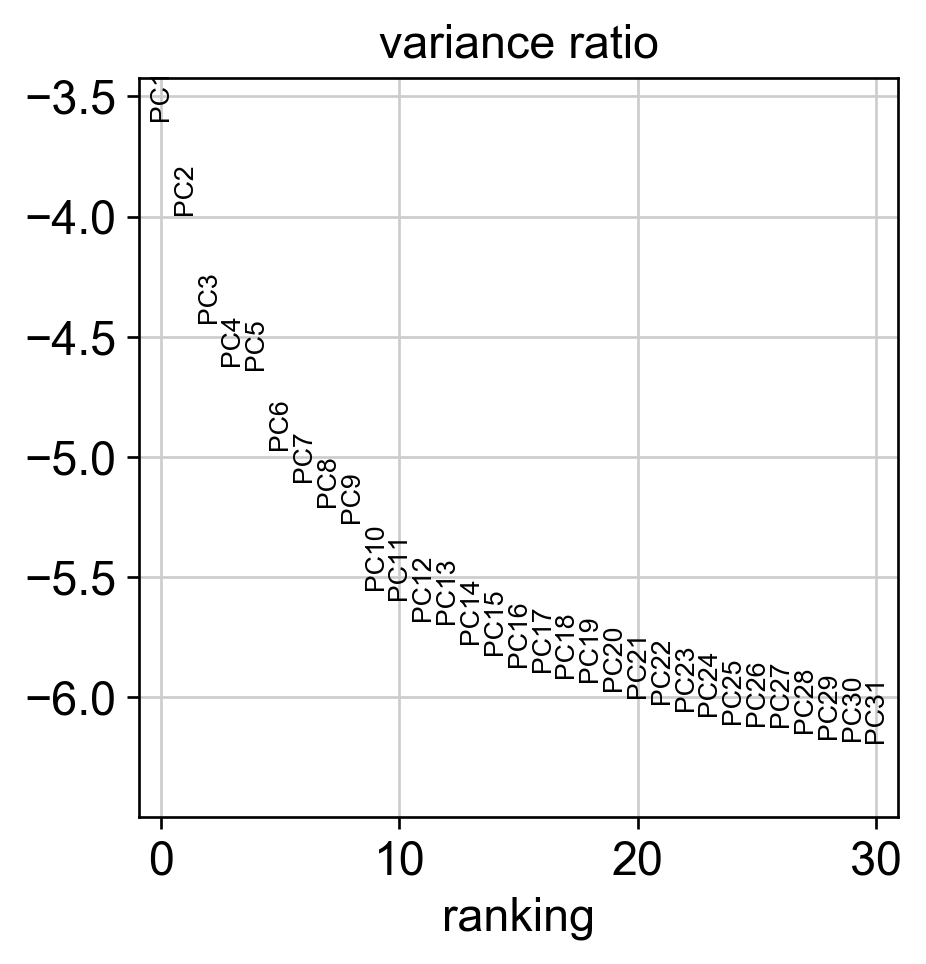

In [19]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [20]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10) 

In [21]:
# run umap
sc.tl.umap(adata) 

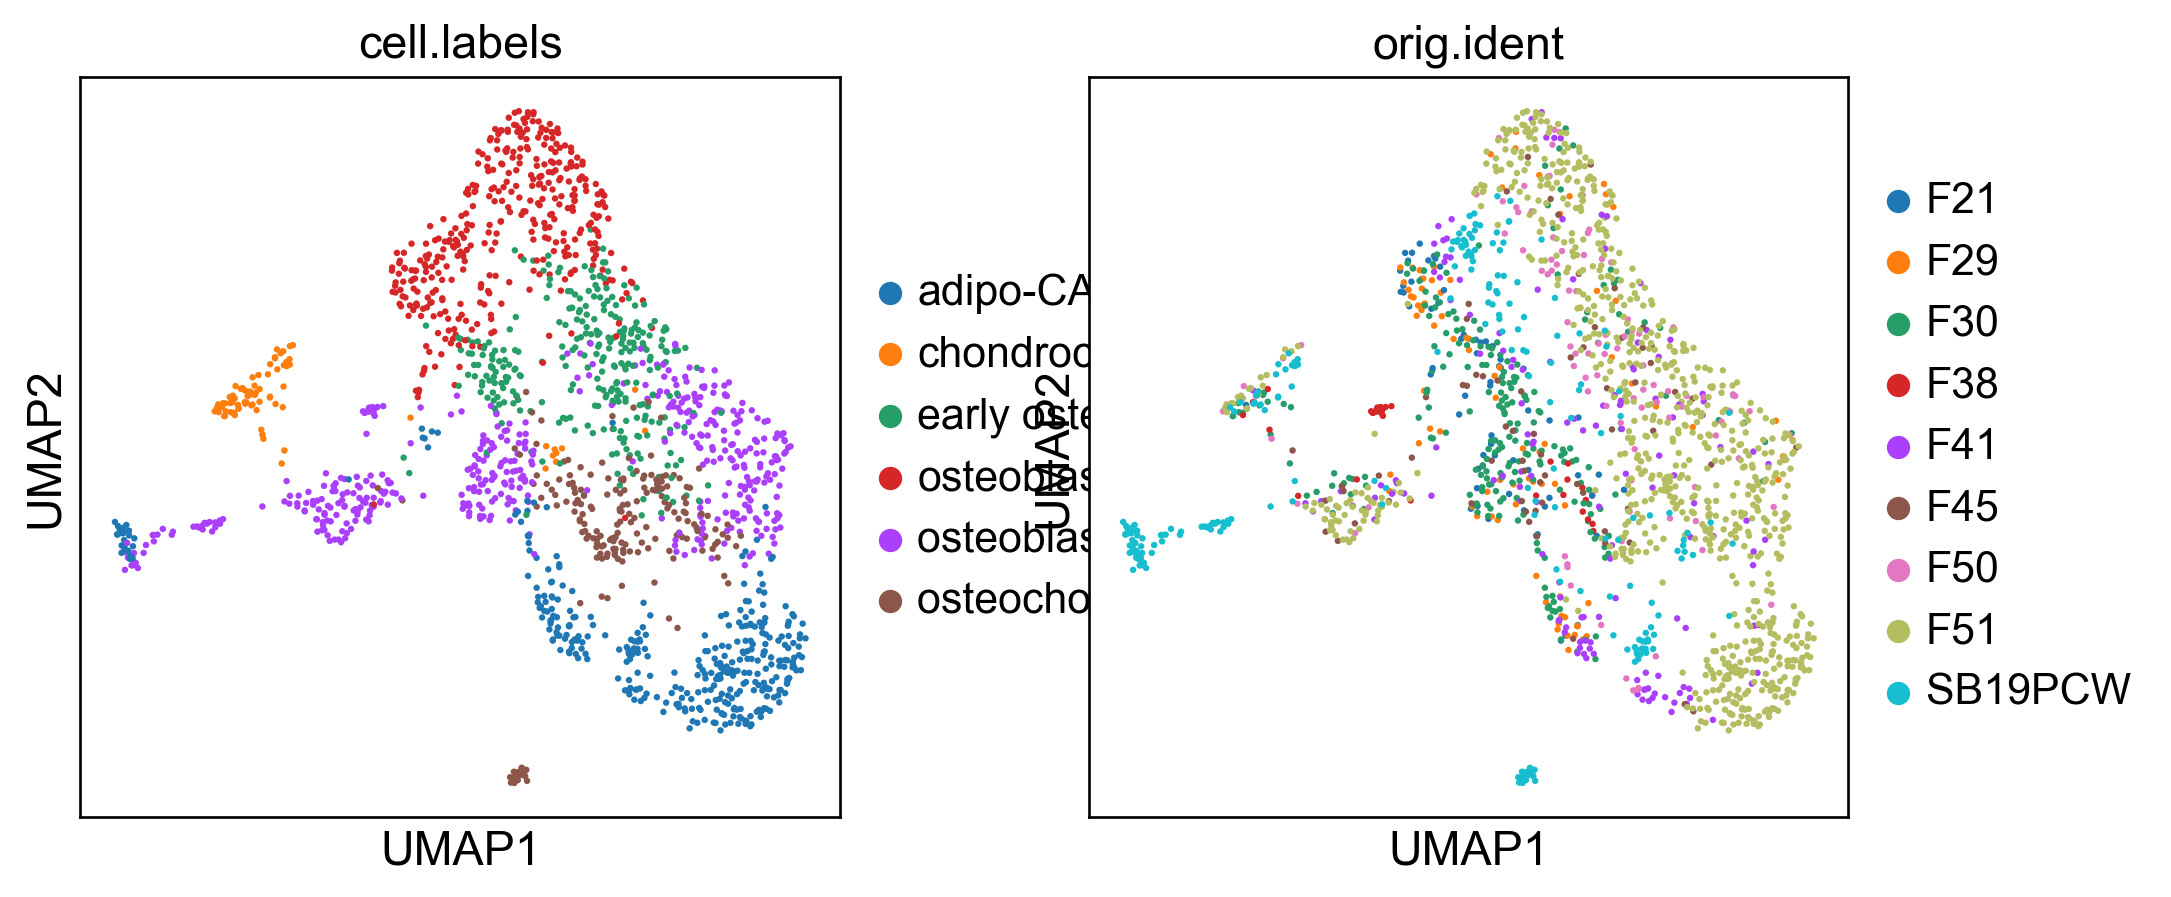

In [22]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

# Run harmony batch correction

In [23]:
#harmony prep - save pca and batch (sample) metadata columns 
pca = adata.obsm['X_pca']
batch = adata.obs['orig.ident']

In [24]:
# load up harmony in rpy2
%load_ext rpy2.ipython

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [25]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

hem = HarmonyMatrix(pca, batch, theta=3, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

R[write to console]: Harmony 7/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write t

In [26]:
# save old pca values or orig.pca and save batch corrected pca results in anndata object as x_pca
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

# Add dimensional reduction post-harmony

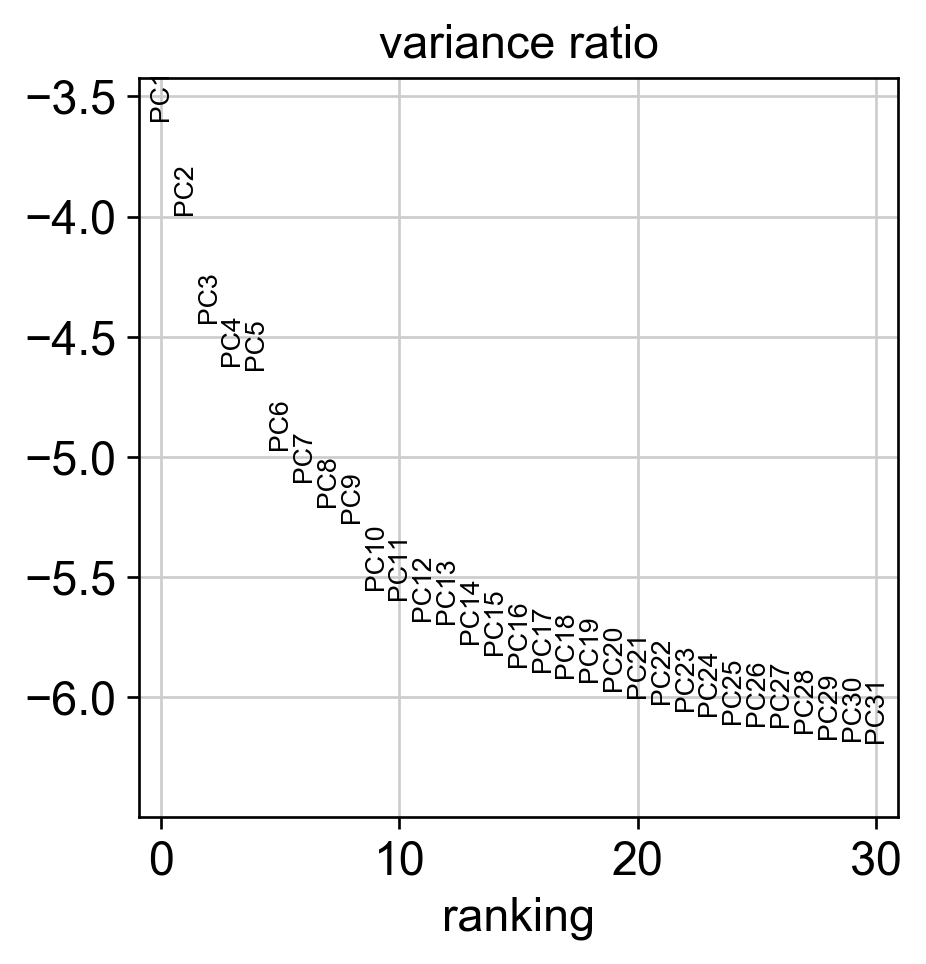

In [27]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [28]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=30) 

In [29]:
# run umap
sc.tl.umap(adata)

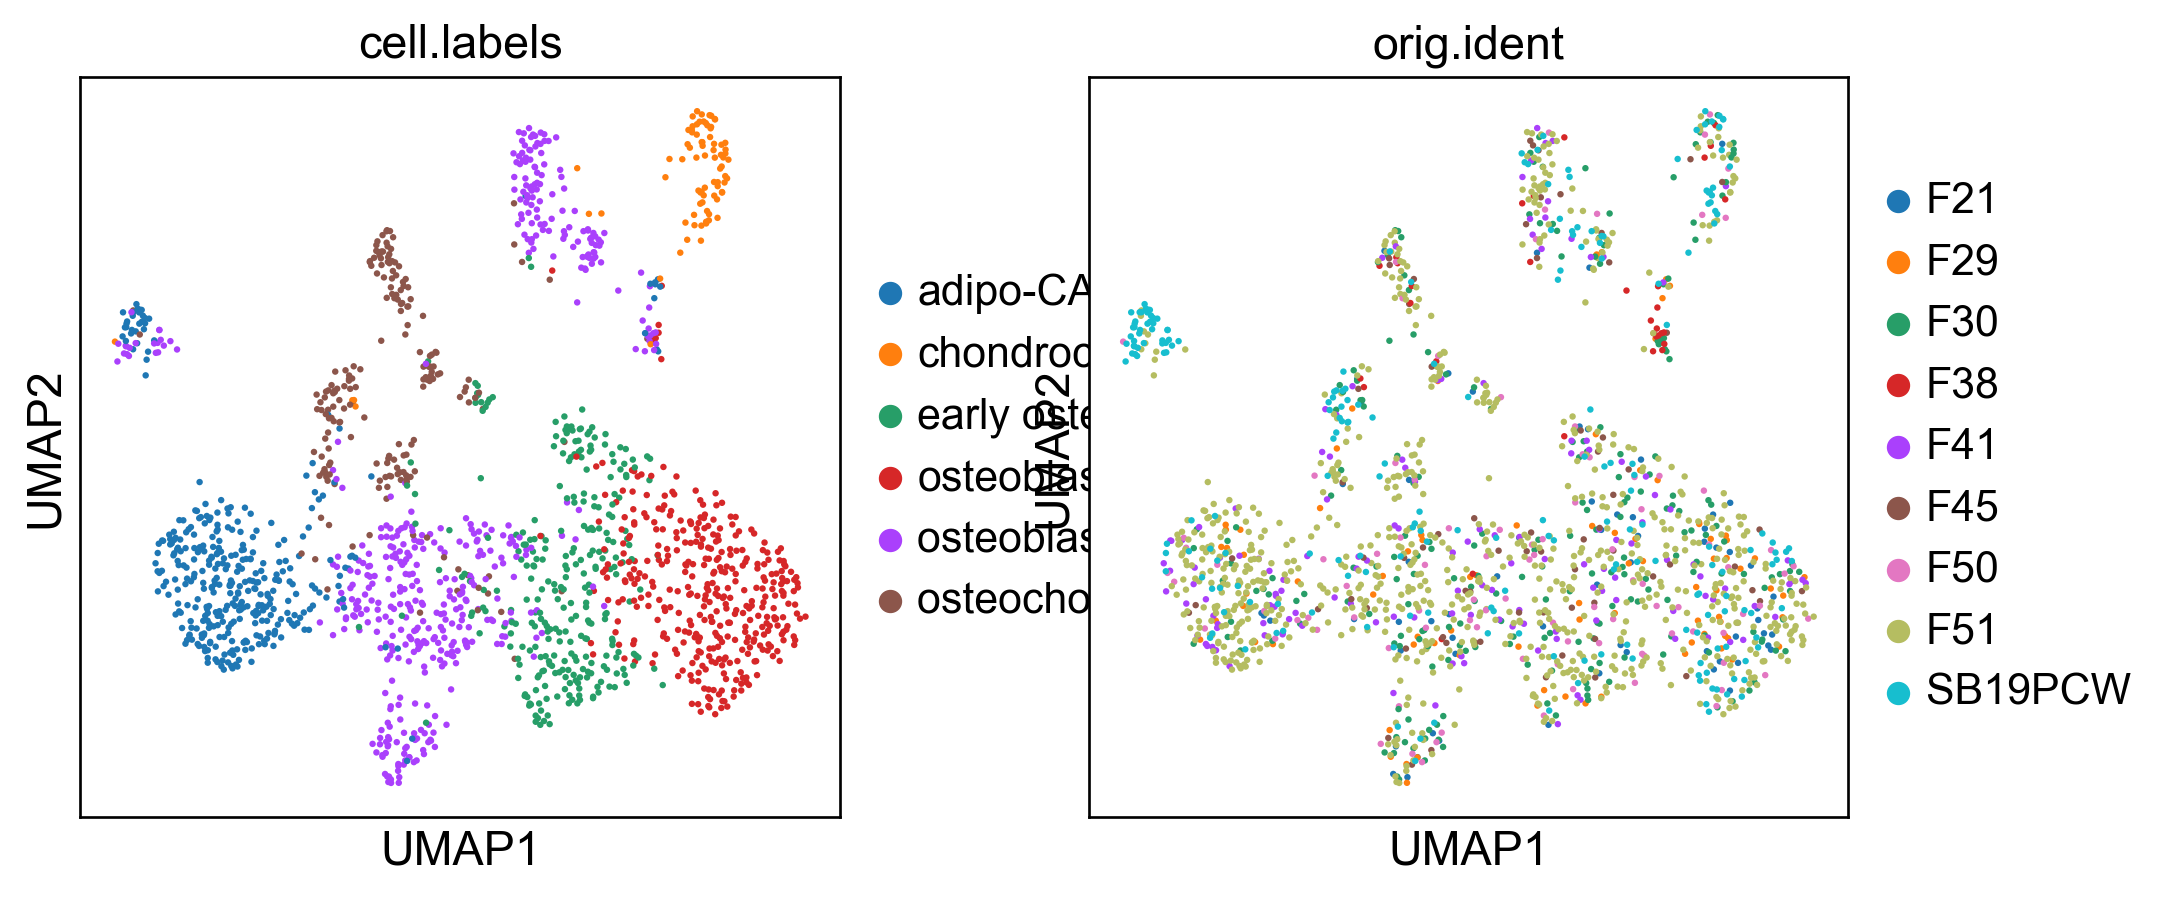

In [30]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

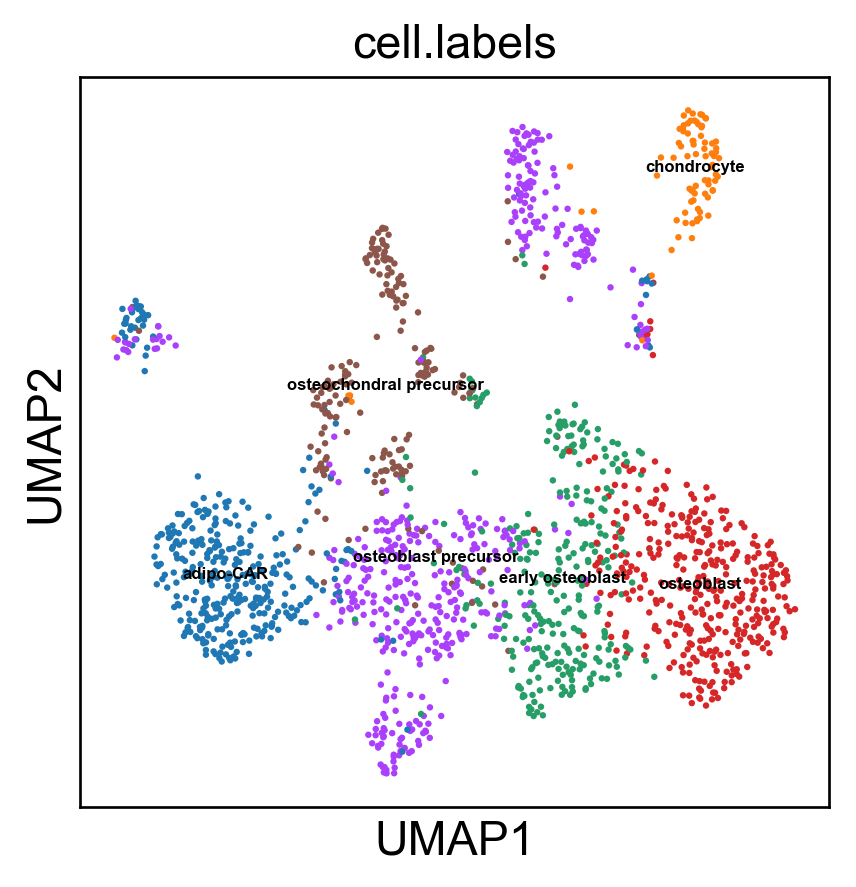

In [31]:
sc.pl.umap(adata, color=['cell.labels'], legend_loc="on data", size=15, legend_fontsize=5) 

# Change the colours 

In [32]:
adata.obs["cell.labels"].cat.categories

Index(['adipo-CAR', 'chondrocyte', 'early osteoblast', 'osteoblast', 'osteoblast precursor', 'osteochondral precursor'], dtype='object')

In [33]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['adipo-CAR', 'chondrocyte', 'early osteoblast', 'osteoblast', 'osteoblast precursor', 'osteochondral precursor'], dtype='object')

In [34]:
final_order = [
'osteochondral precursor',
'adipo-CAR',
'osteoblast precursor',
'early osteoblast',
'osteoblast',
'chondrocyte']

adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories(final_order)

In [35]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['osteochondral precursor', 'adipo-CAR', 'osteoblast precursor', 'early osteoblast', 'osteoblast', 'chondrocyte'], dtype='object')

In [36]:
adata.obs["cell.labels"].cat.categories[2]

'osteoblast precursor'

In [37]:
new_colors = np.array(adata.uns["cell.labels_colors"])

new_colors[[0]] = '#D43D6A' # osteochondral precursor
new_colors[[1]] = '#F3C19F' # adipo-CAR
new_colors[[2]] = '#8E88A8' # osteoblast precursor
new_colors[[3]] = '#86B3E0' # early osteoblast
new_colors[[4]] = '#3B50A2' # osteoblast
new_colors[[5]] = '#A9479A' # chondrocyte

adata.uns["cell.labels_colors"] = new_colors

new_colors

array(['#D43D6A', '#F3C19F', '#8E88A8', '#86B3E0', '#3B50A2', '#A9479A'],
      dtype='<U7')

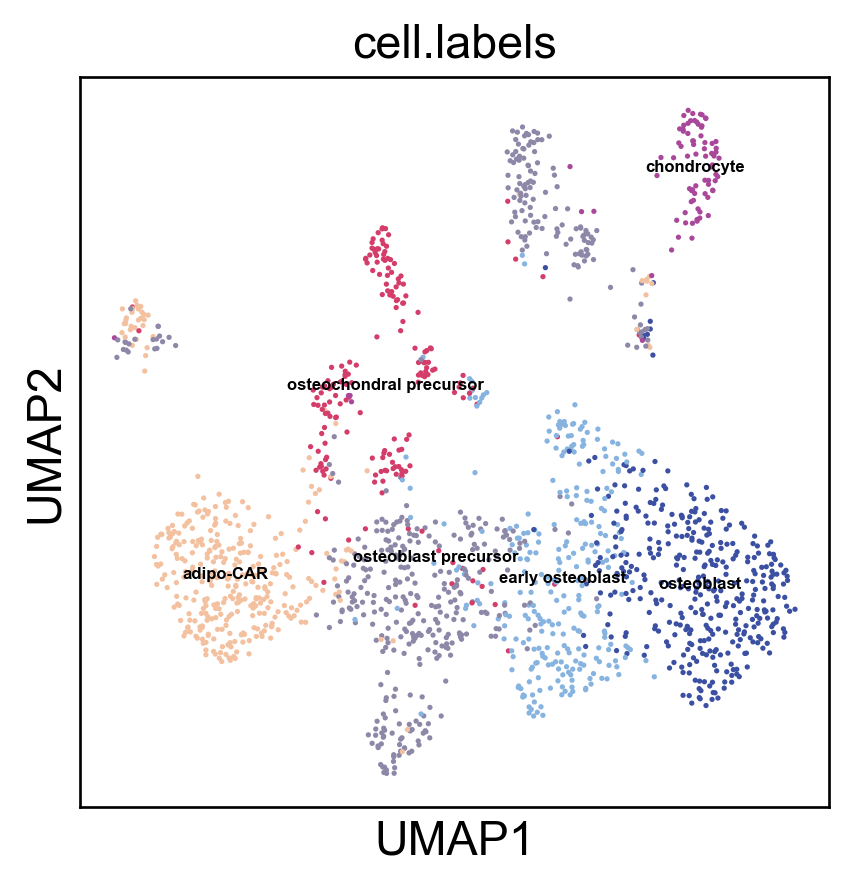

In [38]:
sc.pl.umap(adata, color=['cell.labels'], size=10, legend_loc="on data", legend_fontsize=5) 

# Run an FDG and save

In [39]:
# run fdg 
# As an input, FDG requires PCA coordinates and a snn graph. must redo snn graph if re-running fdg on subsets 
sc.tl.draw_graph(adata, init_pos='X_pca', layout='fa')

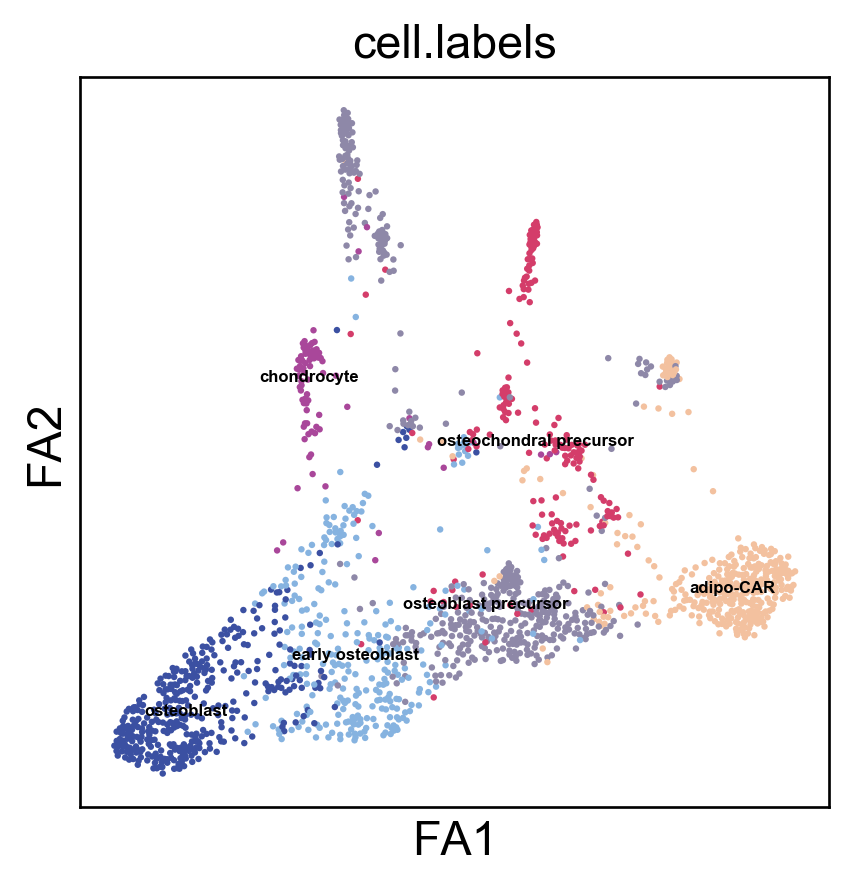

In [40]:
sc.pl.draw_graph(adata, color='cell.labels', layout='fa', legend_loc="on data", size=15, legend_fontsize=5) 

In [41]:
sc.pl.draw_graph(adata, color='cell.labels', layout='fa', size=15, show=False, save='_fig4c_osteochondral_fdg_cell_labels_legoff_20200512.pdf')

# Save the data

In [42]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [43]:
adata.X

<1760x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 4628001 stored elements in Compressed Sparse Row format>

In [44]:
adata.raw.X

<1760x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 5212968 stored elements in Compressed Sparse Row format>

In [45]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig4c_osteochondral_fdg_20200512.h5ad")

# Load in the processed the FBM stromal cells 

In [3]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig4c_osteochondral_fdg_20200512.h5ad")

In [4]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
osteochondral precursor    191
adipo-CAR                  359
osteoblast precursor       463
early osteoblast           291
osteoblast                 375
chondrocyte                 81
dtype: int64

In [5]:
adata.shape

(1760, 33712)

# Add stage into metadata

In [6]:
adata.obs["fetal.ids"].unique().tolist()

['F21_male_16+2PCW',
 'F29_female_17+0PCW',
 'F30_male_14+3PCW',
 'F38_male_12PCW',
 'F41_female_16PCW',
 'F45_female_13+6PCW',
 'F50_female_15PCW',
 'F51_female_15PCW',
 'SB19PCW']

In [7]:
fetal_ids = [
 'F38_male_12PCW', 'F45_female_13+6PCW',
 'F30_male_14+3PCW','F50_female_15PCW', 'F51_female_15PCW',
 'F41_female_16PCW', 'F21_male_16+2PCW', 'F29_female_17+0PCW']

stage_ids = ["Stage 1", "Stage 1", 
            "Stage 2", "Stage 2", "Stage 2", 
             "Stage 3", "Stage 3", "Stage 3"]

adata.obs["stage"] = adata.obs["fetal.ids"].replace(fetal_ids, stage_ids)

# Run gene enrichments

In [8]:
lit_MSC_genes = ['MCAM',
'NGFR',
'ITGAV',
'THY1',
'ITGA1',
'PDGFRB']

sc.tl.score_genes(adata, gene_list=lit_MSC_genes, score_name="MSC_enrichment_lit")

In [9]:
limb_MSC_genes = ['MECOM',
'CSRP2',
'PXB1',
'SOX11',
'MEIS2']

sc.tl.score_genes(adata, gene_list=limb_MSC_genes, score_name="MSC_enrichment_limb")

In [10]:
sc.pl.draw_graph(adata, color=['MSC_enrichment_lit', 'MSC_enrichment_limb'], layout='fa', size=20,  
                 show=False, save='_fig4d_msc_enrichment_cell_labels_legoff_20200513.pdf', vmin=-1, vmax=3)

... storing 'stage' as categorical


In [11]:
#for i in adata.obs["fetal.ids"].unique().tolist():
#    print(i)
#    subset = adata[adata.obs['fetal.ids'].isin([i])].copy()
#    sc.pl.umap(subset, color=['MSC_enrichment'], size=20, save = str(i) + "figs4c_msc_enrichment_preharmony.pdf") 